# Woods (binary)

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

Adding [/home/arc/Projects/pwr/pyalcs-experiments] to sys.path


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

from pylab import cm
import pathlib

from lcs import Perception

import gym
# noinspection PyUnresolvedReferences
import gym_woods

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [3]:
from notebooks import get_from_cache_or_run

# Import utils functions
%run utils/experiments.py
%run utils/metrics.py
%run utils/plots.py
%run utils/payoff_landscape.py
%run utils/basic_rl.py

In [4]:
# Plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

# Common color palette
palette = cm.get_cmap('Paired', 5)

COLORS = {
    'ACS2': palette(0),
    'AACS2_v1': palette(1),
    'AACS2_v2': palette(2),
    'Q-Learning': palette(3),
    'R-Learning': palette(4)
}

## Environment setup

In [5]:
class BinaryAdapter(gym.ObservationWrapper):
    def observation(self, observation):
        result = []
        for el in observation:
            if el == 'F':
                result.extend(['1', '1', '0'])
            if el == 'G':
                result.extend(['1', '1', '1'])
            if el == 'O':
                result.extend(['0', '1', '0'])
            if el == 'Q':
                result.extend(['0', '1', '1'])
            if el == '.':
                result.extend(['0', '0', '0'])

        return result

In [6]:
env = BinaryAdapter(gym.make('Woods1-v0'))
env.reset()

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [7]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/{env.unwrapped.__class__.__name__}-binary'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/anticipatory-classifier-system-with-average-reward-criterion-in-discretized-multi-step-environments/cache/Woods1-binary'

States mapping and helper functions

In [8]:
state_actions = env.unwrapped._state_action()
state_actions

{('0', '0'): [0, 1, 2, 4, 5, 6, 7],
 ('1', '0'): [0, 1, 2, 5, 6, 7],
 ('2', '0'): [0, 1, 2, 3, 6, 7],
 ('3', '0'): [0, 1, 2, 3, 4, 6, 7],
 ('4', '0'): [0, 1, 2, 3, 4, 5, 6, 7],
 ('0', '1'): [0, 1, 4, 5, 6, 7],
 ('4', '1'): [0, 1, 2, 3, 4, 6, 7],
 ('0', '2'): [0, 4, 5, 6, 7],
 ('4', '2'): [0, 1, 2, 3, 4, 7],
 ('0', '3'): [0, 3, 4, 5, 6, 7],
 ('4', '3'): [0, 1, 2, 3, 4, 5],
 ('0', '4'): [0, 2, 3, 4, 5, 6, 7],
 ('1', '4'): [2, 3, 4, 5, 6, 7],
 ('2', '4'): [2, 3, 4, 5, 6],
 ('3', '4'): [1, 2, 3, 4, 5, 6],
 ('4', '4'): [0, 1, 2, 3, 4, 5, 6]}

In [9]:
# number of unique state-action pairs
sum(len(v) for v in state_actions.values())

101

In [10]:
state_id = 0
state_action_id = 0

sp = {}

for state, actions in state_actions.items():
    for action in actions:
        sp[state_action_id] = dict(
            state_id=state_id,
            perception=env.observation(env.unwrapped._perception(int(state[0]), int(state[1]))),
            action=action)
        state_action_id += 1
        
    state_id += 1

len(sp)

101

In [11]:
# Helper function for getting state ID based on agent perception
def get_state_id(p):
    for sa in sp.values():
        if sa['perception'] == p:
            return sa['state_id']
    
    return None

## Basic Metrics
Examine population size, rho parameter and exploitation capabilities.

In [12]:
# Params
learning_rate = 0.8
discount_factor = 0.95
epsilon = 0.8
zeta = 0.0001

# Set ACS2/AACS2 configuration parameter dictionary
basic_cfg = {
    'perception_bits': 24,
    'possible_actions': 8,
    'do_ga': True,
    'beta': learning_rate,
    'epsilon': epsilon,
    'gamma': discount_factor,
    'zeta': zeta,
    'user_metrics_collector_fcn': common_metrics,
    'biased_exploration_prob': 0,
    'metrics_trial_freq': 1
}

# below took 5 mins
trials = 5_000 # 50k
experiments = 1  # 5

In [13]:
%%time

p_acs2, p_aacs2v1, p_aacs2v2, agg_df = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-trials-over-{experiments}-exp.dill',
    lambda: avg_experiments(experiments, fun=lambda: run_experiments_alternating(trials=trials, env=env, params=basic_cfg)))

CPU times: user 3.56 ms, sys: 15.8 ms, total: 19.4 ms
Wall time: 18.4 ms


In [14]:
%%time

init_Q = np.zeros((len(state_actions), env.action_space.n))

q_learning_metrics = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-qlearning-trials-over-{experiments}-exp.dill',
    lambda: run_q_learning_alternating(experiments, trials, env, epsilon, learning_rate, discount_factor, init_Q, perception_to_state_mapper=get_state_id)
)

CPU times: user 5.35 ms, sys: 554 µs, total: 5.9 ms
Wall time: 4.36 ms


In [15]:
%%time

init_R = np.zeros((len(state_actions), env.action_space.n))

r_learning_metrics = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-rlearning-trials-over-{experiments}-exp.dill',
    lambda: run_r_learning_alternating(experiments, trials, env, epsilon, learning_rate, zeta, init_R, perception_to_state_mapper=get_state_id)
)

CPU times: user 5.33 ms, sys: 542 µs, total: 5.87 ms
Wall time: 5.29 ms


In [16]:
agg_df = pd.concat([
    agg_df,
    pd.DataFrame(q_learning_metrics).groupby(['agent', 'trial', 'phase']).mean().reset_index(level='phase'),
    pd.DataFrame(r_learning_metrics).groupby(['agent', 'trial', 'phase']).mean().reset_index(level='phase')]
)

agg_df

phase  steps_in_trial         rho  population  reliable
agent      trial                                                           
AACS2_v1   0      explore             6.0    0.000000         4.0       0.0
           1      exploit             2.0    0.000000         4.0       0.0
           2      explore            38.0    0.000000        22.0       2.0
           3      exploit             3.0    0.000000        22.0       2.0
           4      explore            19.0    0.100000        23.0       6.0
...                   ...             ...         ...         ...       ...
R-Learning 4995   exploit             2.0  392.616287         NaN       NaN
           4996   explore            15.0  392.227782         NaN       NaN
           4997   exploit             2.0  392.310142         NaN       NaN
           4998   explore            18.0  392.000439         NaN       NaN
           4999   exploit             1.0  392.122048         NaN       NaN

[25000 rows x 5 columns]

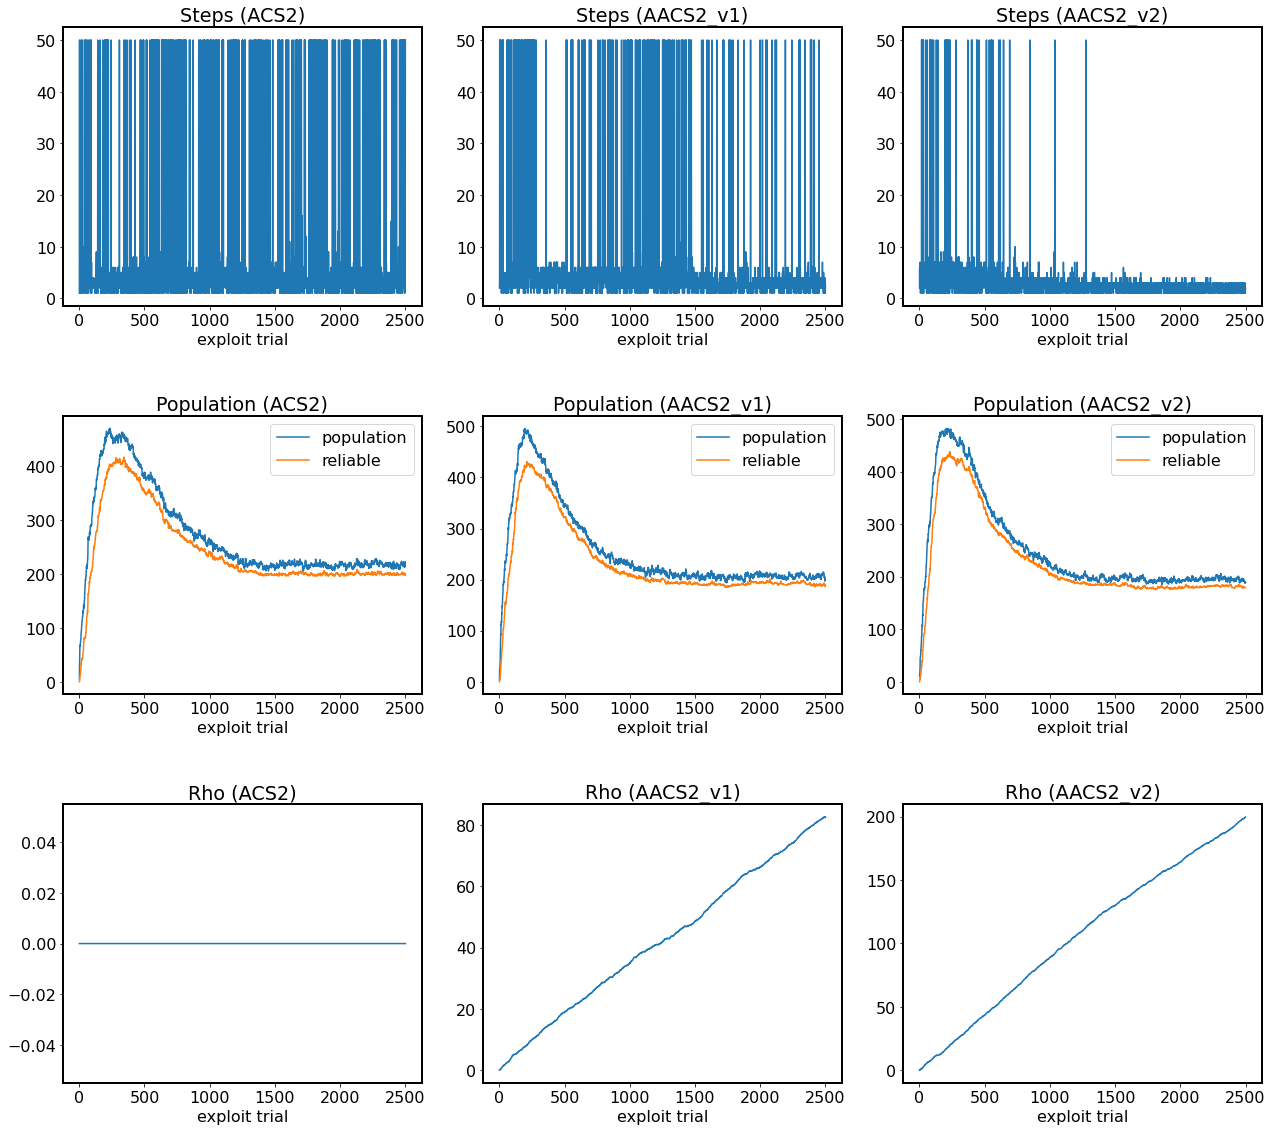

In [17]:
plot_exploit_results(agg_df)

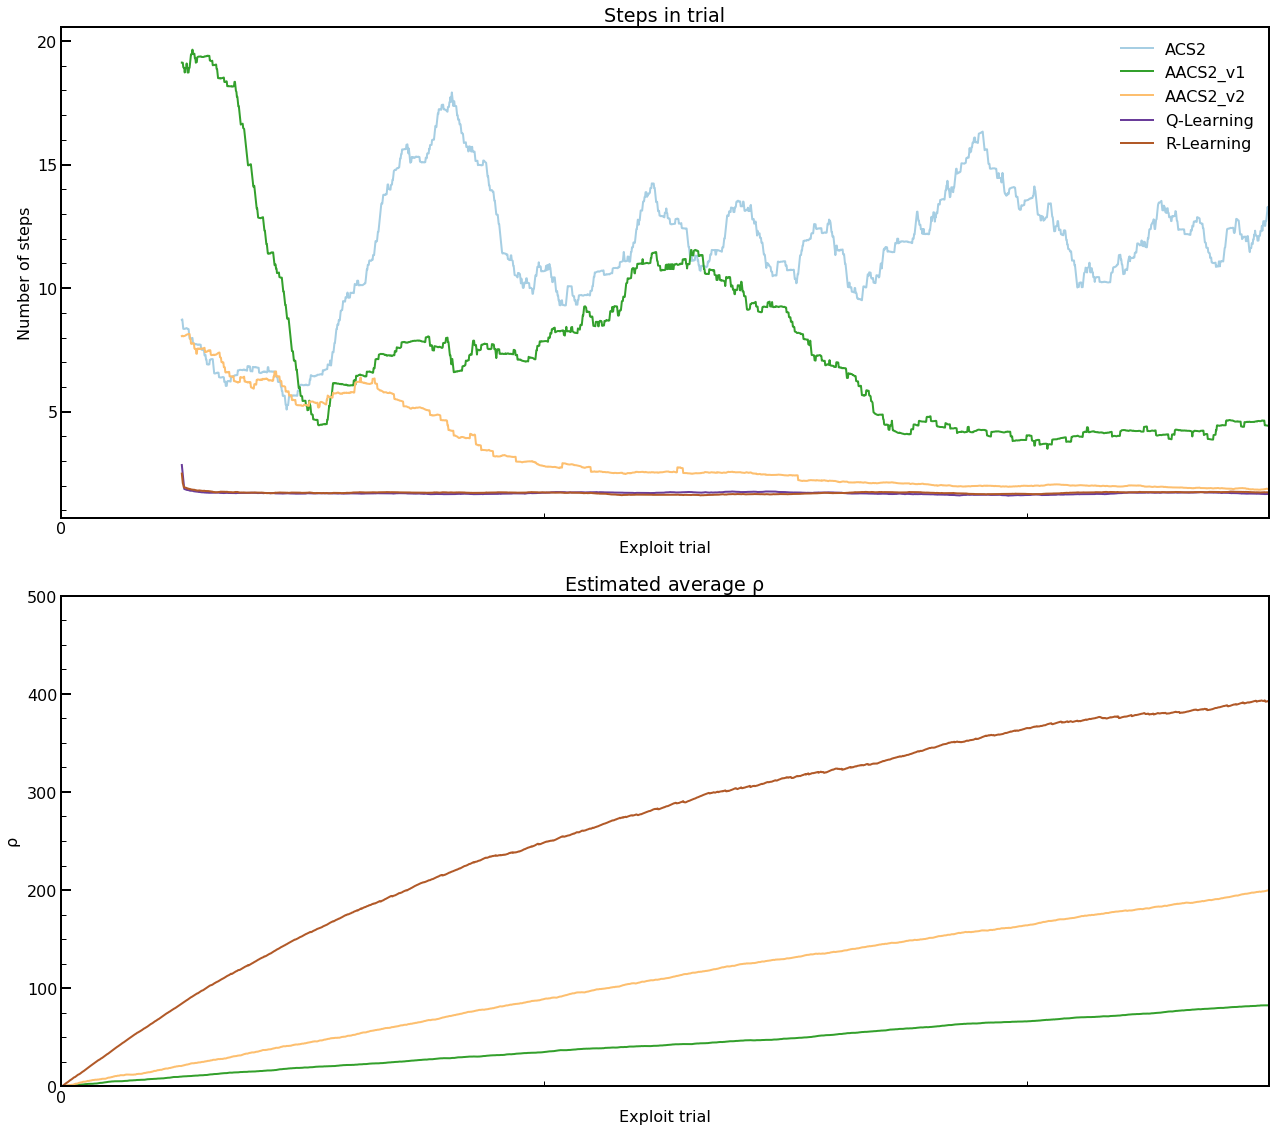

In [18]:
def plot_pop_and_rho(df):
    expl_df = df[df['phase'] == 'exploit']
    xmax = trials/2
    
    fig, axs = plt.subplots(2, 1, figsize=(18, 16))
    
    # Steps in trial plot
    for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2', 'Q-Learning', 'R-Learning']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)
        
        alg_df['steps_in_trial'].rolling(window=250).mean().plot(ax=axs[0], label=alg, linewidth=2, color=COLORS[alg])
    
    axs[0].set_xlabel("Exploit trial")
    axs[0].set_xlim(0, xmax)
    axs[0].xaxis.set_major_locator(MultipleLocator(5000))
    axs[0].xaxis.set_minor_locator(MultipleLocator(1000))
    axs[0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    axs[0].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[0].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[0].set_ylabel("Number of steps")
    axs[0].yaxis.set_major_locator(MultipleLocator(5))
    axs[0].yaxis.set_minor_locator(MultipleLocator(1))
    axs[0].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[0].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[0].set_title('Steps in trial')
    axs[0].legend(loc='upper right', frameon=False)
    
    # Rho plot
    for alg in ['AACS2_v1', 'AACS2_v2', 'R-Learning']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)
        
        alg_df['rho'].rolling(window=1).mean().plot(ax=axs[1], label=alg, linewidth=2, color=COLORS[alg])
        
    axs[1].set_xlabel("Exploit trial")
    axs[1].set_xlim(0, xmax)
    axs[1].xaxis.set_major_locator(MultipleLocator(5000))
    axs[1].xaxis.set_minor_locator(MultipleLocator(1000))
    axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    axs[1].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[1].set_ylabel(r"$\mathregular{\rho}$")
    axs[1].yaxis.set_major_locator(MultipleLocator(100))
    axs[1].yaxis.set_minor_locator(MultipleLocator(25))
    axs[1].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    axs[1].set_ylim(0, 500)
    
    axs[1].set_title(r'Estimated average $\mathregular{\rho}$')
    
    fig.tight_layout()
    # plt.savefig('plots/woods-bin-steps_rho.pdf', transparent=False, bbox_inches='tight')
    plt.show()
    
    
plot_pop_and_rho(agg_df)

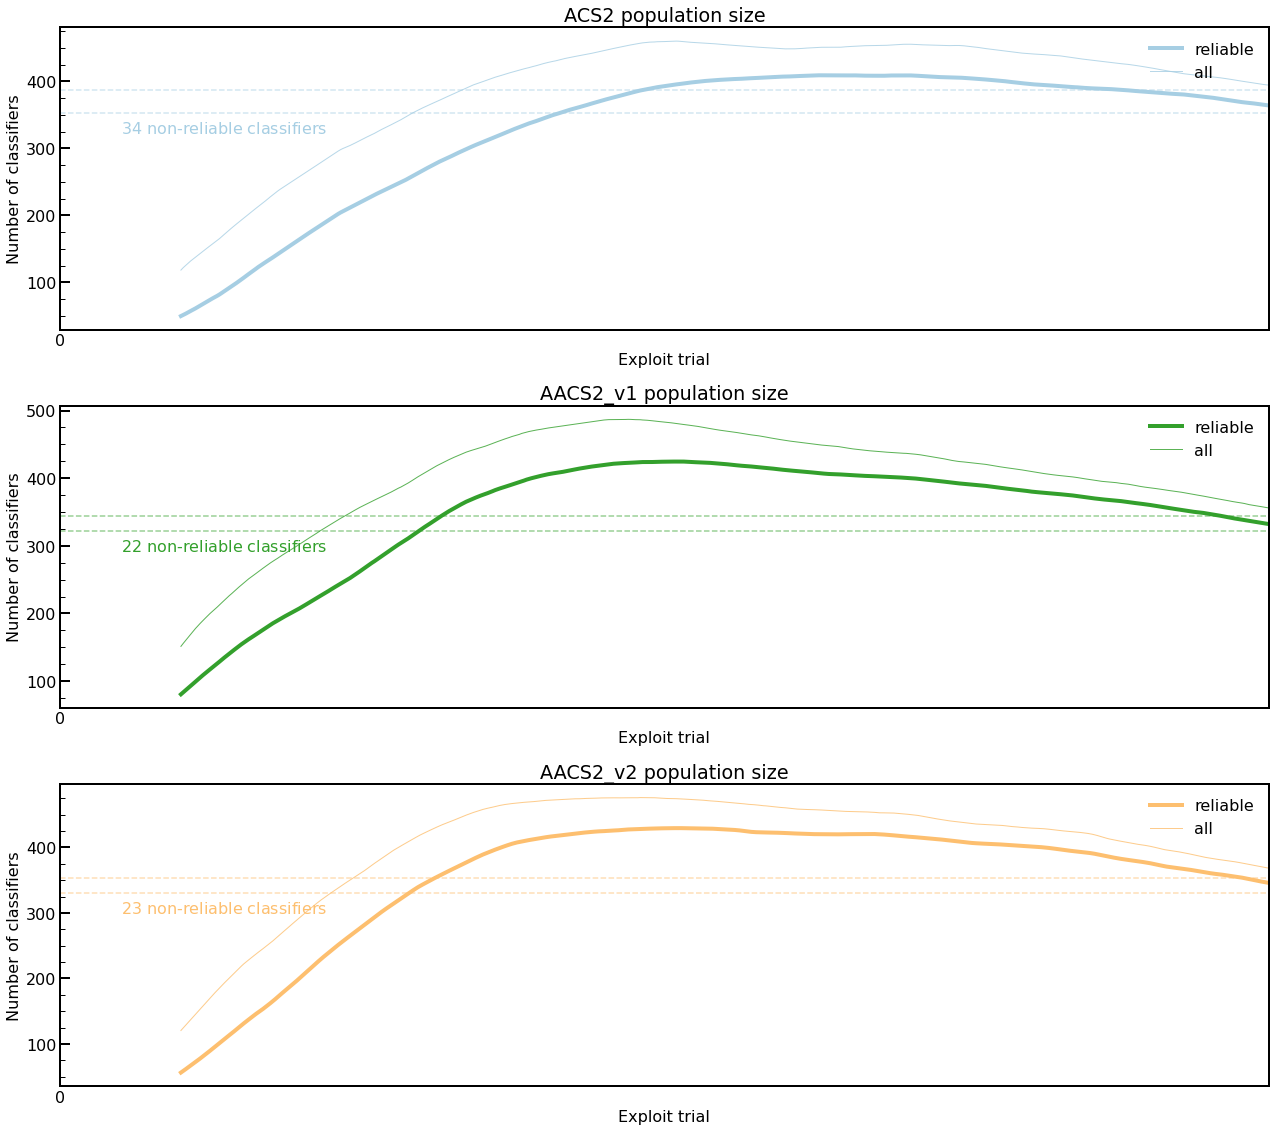

In [19]:
def plot_population(df):
    expl_df = df[df['phase'] == 'exploit']
    
    fig, axs = plt.subplots(3, 1, figsize=(18, 16))
    
    x_lim = int(trials/10)
    
    for idx, alg in enumerate(['ACS2', 'AACS2_v1', 'AACS2_v2']):
        alg_df = expl_df.loc[alg]
        index = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(index, inplace=True)
        
        alg_df['reliable'].rolling(window=50).mean().plot(ax=axs[idx], label='reliable', linewidth=4, color=COLORS[alg])
        alg_df['population'].rolling(window=50).mean().plot(ax=axs[idx], label='all', linewidth=1, color=COLORS[alg], alpha=0.8)
        
        last_rel_count = alg_df['reliable'].iloc[x_lim] 
        last_pop_count = alg_df['population'].iloc[x_lim] 
        axs[idx].hlines(last_rel_count, 0, x_lim, linestyles='dashed', color=COLORS[alg], alpha=0.5)
        axs[idx].hlines(last_pop_count, 0, x_lim, linestyles='dashed', color=COLORS[alg], alpha=0.5)
        axs[idx].text(x_lim/20, last_rel_count-30, fr'${(last_pop_count-last_rel_count):.0f}$ non-reliable classifiers', color=COLORS[alg])
    
        axs[idx].set_xlabel("Exploit trial")
        axs[idx].set_xlim(0, x_lim)
        axs[idx].xaxis.set_major_locator(MultipleLocator(1000))
        axs[idx].xaxis.set_minor_locator(MultipleLocator(500))
        axs[idx].xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
        axs[idx].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
        axs[idx].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')

        axs[idx].set_ylabel("Number of classifiers")
        axs[idx].yaxis.set_major_locator(MultipleLocator(100))
        axs[idx].yaxis.set_minor_locator(MultipleLocator(25))
        axs[idx].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
        axs[idx].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')

        axs[idx].set_title(f'{alg} population size')
        axs[idx].legend(loc='upper right', frameon=False)
    
    fig.tight_layout()
    # plt.savefig('plots/woods-bin-population.pdf', transparent=False, bbox_inches='tight')
    plt.show()
    
    
plot_population(agg_df)

## Payoff Landscape

### Data preparation

In [20]:
# Take first of each algorithm pass population for presenting payoff landscape 
pop_acs2 = p_acs2[0]
pop_aacs2v1 = p_aacs2v1[0]
pop_aacs2v2 = p_aacs2v2[0]

In [21]:
# see how many classifiers are reliable across the whole population
for alg, pop in zip(['ACS2', 'AACS2-v1', 'AACS2-v2'], [pop_acs2, pop_aacs2v1, pop_aacs2v2]):
    print(f"{alg}: {len([cl for cl in pop if cl.is_reliable()])}/{len(pop)}")

ACS2: 198/221
AACS2-v1: 187/200
AACS2-v2: 179/189


#### Q-learning

In [22]:
%%time

init_Q = np.zeros((len(state_actions), env.action_space.n))  # initial Q-table
Q, _ = get_from_cache_or_run(f'{cache_prefix}/{trials}-trials-qlearning.dill',
                          lambda: qlearning(env, trials, init_Q, epsilon, learning_rate, discount_factor, perception_to_state_mapper=get_state_id))

CPU times: user 427 µs, sys: 101 µs, total: 528 µs
Wall time: 357 µs


#### R-learning

In [23]:
%%time

init_R = np.zeros((len(state_actions), env.action_space.n))  # initial R-table
R, rho, _ = get_from_cache_or_run(f'{cache_prefix}/{trials}-trials-rlearning.dill',
                               lambda: rlearning(env, trials, init_R, epsilon, learning_rate, zeta, perception_to_state_mapper=get_state_id))

CPU times: user 358 µs, sys: 85 µs, total: 443 µs
Wall time: 297 µs


In [24]:
rho

266.91908346153576

### Landscape plot

In [25]:
payoffs = {}

for state_action_id, data in sp.items():
    state_id = data['state_id']
    p = Perception((data['perception']))
    action = data['action']
        
    # ACS2
    acs2_match_set = pop_acs2.form_match_set(p)
    acs2_action_set = acs2_match_set.form_action_set(action)

    # AACS2_v1
    aacs2v1_match_set = pop_aacs2v1.form_match_set(p)
    aacs2v1_action_set = aacs2v1_match_set.form_action_set(action)

    # AACS2_v2
    aacs2v2_match_set = pop_aacs2v2.form_match_set(p)
    aacs2v2_action_set = aacs2v2_match_set.form_action_set(action)

    # Check if all states are covered
    for alg, action_set in zip(['ACS2', 'AACS2_v1', 'AACS2_v2'],
                               [acs2_action_set, aacs2v1_action_set,
                                aacs2v2_action_set]):
        if len(action_set) == 0:
            print(f"WARN: No {alg} classifiers for perception: {p}, action: {action}")

    payoffs[state_action_id] = {
        'ACS2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
        'AACS2_v1': np.mean(list(map(lambda cl: cl.r, aacs2v1_action_set))),
        'AACS2_v2': np.mean(list(map(lambda cl: cl.r, aacs2v2_action_set))),
        'Q-Learning': Q[state_id, action],
        'R-Learning': R[state_id, action]
    }

WARN: No ACS2 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 4
WARN: No AACS2_v2 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 4
WARN: No ACS2 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 6
WARN: No AACS2_v1 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 7
WARN: No AACS2_v2 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 7
WARN: No AACS2_v2 classifiers for perception: 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 4


/home/arc/miniconda3/envs/pyalcs-experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arc/miniconda3/envs/pyalcs-experiments/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


WARN: No AACS2_v1 classifiers for perception: 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 0
WARN: No ACS2 classifiers for perception: 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 0
WARN: No AACS2_v1 classifiers for perception: 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 0
WARN: No AACS2_v2 classifiers for perception: 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 0
WARN: No AACS2_v2 classifiers for perception: 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 5
WARN: No AACS2_v2 classifiers for perception: 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0, action: 7
WARN: No AACS2_v2 classifiers for perception: 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0, action: 6
WARN: No AACS2_v1 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0, action: 0
WARN: No AACS2_v1 classifiers for perception: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0, action: 1
WARN: No AACS2_v1 classifiers for perception: 0 0 0 0 0 0 0

In [26]:
len(payoffs)

101

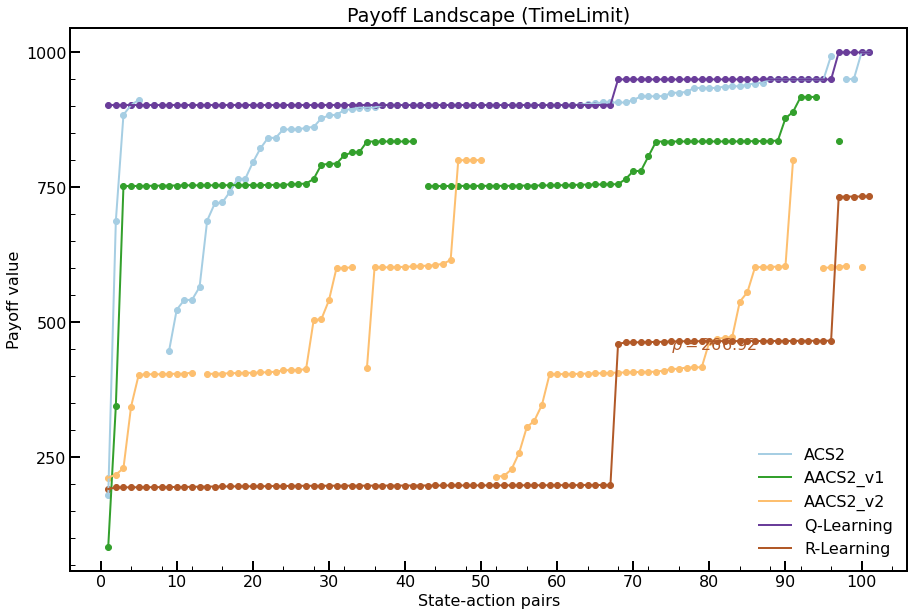

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)

for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2', 'Q-Learning', 'R-Learning']:
    y = sorted([v[alg] for k, v in payoffs.items()])
    
    plt.scatter(x, y, color=COLORS[alg])
    plt.plot(x, y, label=alg,  linewidth=2, color=COLORS[alg])

# x-axis
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
ax.set_xlabel("State-action pairs")

# y-axis
ax.yaxis.set_major_locator(MultipleLocator(250))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
ax.set_ylabel("Payoff value")

# others
ax.set_title(f"Payoff Landscape ({env.env.__class__.__name__})")
ax.text(75, 450, fr'$\rho={rho:.2f}$', color=COLORS['R-Learning'])
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=False)

# save fig
# plt.savefig('plots/woods-bin-payofflandscape.pdf', transparent=False, bbox_inches='tight')
plt.show()